# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import segmentation
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import logging
import time
import pandas as pd

# Define Color Map

In [4]:
# Define a dictionary mapping RGB colors to class labels
# The key is the (R, G, B) tuple, and the value is the corresponding class label
color_map = {
    (128, 64, 128): 1,    # Road
    (244,35,232): 2,      # Sidewalk
    (70, 70, 70): 3,      # Building
    (102,102,156): 4,     # Wall
    (190, 153, 153): 5,   # Fence
    (107, 142, 35): 6,    # Vegetation
    (152,251,125): 7,     # Terrain
    (70, 130, 180): 8,    # Sky
    (220, 20, 60): 9,     # Person
    (0, 0, 142): 10,      # Car
    (119, 11, 32): 11,    # Bicycle
    (0, 0, 230): 12,      # Motorcycle
    (0,0,0): 0,           # Background (can be 0)
}

# Processor class

In [53]:
class Processor:
    def convert_rgb_to_mask(self, mask_folder, output_mask_folder, color_map):
        ''' convert a folder of rgb masks to single channel mask with class indices'''
        os.makedirs(output_mask_folder, exist_ok=True)

        lookup_table = np.zeros((256, 256, 256), dtype=np.uint8)
        for (r, g, b), label in color_map.items():
            lookup_table[r, g, b] = label

        mask_files = [f for f in os.listdir(mask_folder) if f.endswith("png")]

        for mask_filename in tqdm(mask_files, desc="Processing Masks", unit="img"):

            mask_path = os.path.join(mask_folder, mask_filename)
            mask_image = cv2.imread(mask_path)
            mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

            integer_mask = lookup_table[mask_image[...,0], mask_image[...,1], mask_image[...,2]]
    
            output_mask_path = os.path.join(output_mask_folder, mask_filename)
            cv2.imwrite(output_mask_path, integer_mask)     


    def convert_mask_to_rgb(mask, color_map):
        ''' convert an 2D mask with class indices to an rgb mask '''
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()  

        height, width = mask.shape
        rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

        for class_rgb, class_idx in color_map.items():
            rgb_mask[mask == class_idx] = class_rgb  

        return rgb_mask           

In [52]:
# Test Preprocessor class

mask_folder = 'C:/Users/dhoow/Desktop/Computer Vision/lane_segmentation_project/dummy_kitti_dataset/train_masks'
output_mask_folder = 'C:/Users/dhoow/Desktop/Computer Vision/lane_segmentation_project/dummy_kitti_dataset/testing_preprocessed_masks'

preprocessor = Processor()
preprocessor.convert_rgb_to_mask(mask_folder, output_mask_folder, color_map)

Processing Masks: 100%|██████████| 11/11 [00:00<00:00, 25.82img/s]


# Transforms class

In [ ]:
class ToTensorWithoutNormalization:
    def __call__(self, sample):
        mask = np.array(sample)
        mask_tensor = torch.tensor(mask, dtype=torch.long)
        return mask_tensor

# Dataset class

In [12]:
class KITTIdataset(Dataset):
    def __init__(self,image_dir, mask_dir, transform=None, mask_transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_size = image_size

        self.image_names = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.mask_names = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

        assert len(self.image_names) == len(self.mask_names), "Mismatch between image and mask count!"

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.image_size:
            image = image.resize(self.image_size)
            mask = mask.resize(self.image_size)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [14]:
# Test Dataset class and Transforms class

image_dir = 'C:/Users/dhoow/Desktop/Computer Vision/lane_segmentation_project/dummy_kitti_dataset/train_images'
mask_dir = 'C:/Users/dhoow/Desktop/Computer Vision/lane_segmentation_project/dummy_kitti_dataset/train_preprocessed_masks'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    ToTensorWithoutNormalization()
])

dataset = KITTIdataset(image_dir=image_dir, mask_dir=mask_dir,
                       transform=transform, mask_transform=mask_transform)


# Model class

In [15]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.model = segmentation.deeplabv3_resnet101(weights='DEFAULT')
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)['out']

In [34]:
# Test Model class
NUM_CLASSES = 13

model = DeepLabV3Plus(NUM_CLASSES)

In [57]:
#### Not sure what to do with this cell
num_img = dataset.__len__()
BATCH_SIZE = 2
CHECKPOINT_DIR = "experiments"
EXPERIMENT_NAME = '5epochs_local_training'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_size = int(0.6*num_img)
val_size = int(0.2*num_img)
test_size = num_img - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Trainer class (To do)

In [50]:
#### Convert into class
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []

    plt.ion()
    fig, ax = plt.subplots()

    logging.info("Starting training...")

    epoch_progress = tqdm(range(epochs), desc="Training Progress")  

    for epoch in epoch_progress:
        print(f"\n Epoch {epoch + 1}/{epochs}")
        logging.info(f"Epoch {epoch + 1}/{epochs}")

        # Train Phase
        model.train()
        running_train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device),  masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}")
        logging.info(f"Train Loss: {avg_train_loss:.4f}")

        # Validation Phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device),  masks.squeeze(1).long().to(device)

                preds = model(images)
                loss = criterion(preds, masks)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Val Loss: {avg_val_loss:.4f}")
        logging.info(f"Val Loss: {avg_val_loss:.4f}")

        # Update tqdm progress bar
        epoch_progress.set_postfix({"Train Loss": f"{avg_train_loss:.4f}", "Val Loss": f"{avg_val_loss:.4f}"})

        # Update plot
        ax.clear()
        ax.plot(train_losses, label="Train Loss")
        ax.plot(val_losses, label="Val Loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        plt.draw()
        plt.pause(0.1)

        # Learning rate scheduling
        scheduler.step()

    # Save model at the end of training
    checkpoint_path = os.path.join(CHECKPOINT_DIR, EXPERIMENT_NAME )
    torch.save(model.state_dict(), checkpoint_path)
    print("Final model checkpoint saved!")
    logging.info(f"Final model checkpoint saved at {checkpoint_path}")

    # Save the losses to a CSV file
    loss_df = pd.DataFrame({
        'Epoch': range(1, epochs+1),
        'Training Loss': train_losses,
        'Validation Loss': val_losses
    })

    loss_df.to_csv(EXPERIMENT_NAME, index = 'False')

    print("Training Completed!")
    logging.info("Training Completed!")
    plt.ioff()
    plt.show()


# Evaluation class

In [65]:
class Evaluator:
    def compute_iou(self, pred_mask_array, true_mask_array, class_id, color_map):
        
        """
        Computes the Intersection over Union (IoU) for a specific class between 
        the predicted and true segmentation masks.

        Parameters:
            pred_mask_array (numpy.ndarray): The predicted mask 3D array (H, W, 3) 
            true_mask_array (numpy.ndarray): The ground truth mask image 3D array (H, W, 3) 
            class_id (int): The class ID for which to calculate the IoU.
            color_map (dict): The dictionary mapping RGB colors to Class ID.                        

        Returns:
            float: The Intersection over Union (IoU) score for the specified class.
                If there is no overlap (union is zero), returns 0."""
        
        assert pred_mask_array.shape == true_mask_array.shape, "Mask shapes should be the same"
        assert class_id in color_map.values(), "class_ID should be defined in color to class mapping"

        class_rgb = np.array(list(key for key, value in color_map.items() if value == class_id)[0])

        # Reshape the arrays into 2D arrays with 3 columns (RGB)
        reshaped_pred_mask_array = pred_mask_array.reshape(-1, 3)
        reshaped_true_mask_array = true_mask_array.reshape(-1, 3)

        # Create binary masks (1 for the target class, 0 for others)
        pred_lane = np.array([1 if np.all(pix == class_rgb) else 0 for pix in reshaped_pred_mask_array])
        true_lane = np.array([1 if np.all(pix == class_rgb) else 0 for pix in reshaped_true_mask_array])

        # Compute intersection and union
        intersection = np.logical_and(pred_lane, true_lane).sum()
        union = np.logical_or(pred_lane, true_lane).sum()

        # Compute IoU 
        iou = intersection / union if union > 0 else 0
        return iou
    
    def compute_mean_iou(self,model, test_loader, class_id, color_map, device):
        """
        Computes the mean IoU across all images in the test dataset for one class.

        Args:
            model (torch.nn.Module): Trained segmentation model.
            test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
            class_id (int): Class index for which the IoU needs to be computed
            color_map (dict): Mapping from class indices to RGB values.
            device (torch.device): Device (CPU/GPU).

        Returns:
            float: mean iou score."""
        
        model.eval()  
        all_iou = [] 

        with torch.no_grad():  
            for images, true_masks in test_loader:
                images = images.to(device)  
                true_masks = true_masks.to(device)  

                # Get predictions from model
                outputs = model(images)  # (B, num_classes, H, W)
                predicted_masks = torch.argmax(outputs, dim=1)  #  (B, H, W)

                for i in range(images.shape[0]):  
                    # Convert predicted & true masks to RGB
                    true_mask_rgb = Processor.convert_mask_to_rgb(true_masks[i].squeeze(0), color_map)
                    pred_mask_rgb = Processor.convert_mask_to_rgb(predicted_masks[i], color_map)
        
                    iou = self.compute_iou(pred_mask_rgb, true_mask_rgb, class_id, color_map)
                    all_iou.append(iou)

        # Compute final mean IoU per class
        mean_iou_score = sum(all_iou)/len(all_iou)

        return mean_iou_score
        


In [68]:
# Test Evaluator class
# MODEL_PATH = os.path.join(CHECKPOINT_DIR, EXPERIMENT_NAME)
MODEL_PATH = r"C:\Users\dhoow\Desktop\Computer Vision\lane_segmentation_project\experiments\5epochs_local_training"
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

evaluator = Evaluator()
mean_iou = evaluator.compute_mean_iou(model, test_loader,1,color_map, DEVICE)
print(mean_iou)

c:\Users\dhoow\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.0


# Inference class

In [77]:
class Inference:
    def __init__(self, model, color_map, device):
        self.model = model.to(device)
        self.model.eval()
        self.device = device
        self.color_map = color_map
        
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict_from_image_path(self, image_path):
        ''' Make prediction from image file'''

        image = Image.open(image_path).convert('RGB')
        input_tensor = self.image_transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.model(input_tensor)
            predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        predicted_rgb_mask = Processor.convert_mask_to_rgb(predicted_mask, self.color_map)

        return predicted_rgb_mask
    
    def predict_from_test_loader(self, test_loader):
        ''' Make prediction for an image from test_loader'''

        data_iter = iter(test_loader)
        image, _ = next(data_iter)
        image = image[0].unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.model(image)
            predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        predicted_rgb_mask = Processor.convert_mask_to_rgb(predicted_mask, self.color_map)

        return predicted_rgb_mask


In [ ]:
# Test Inference class

inference = Inference(model, color_map, DEVICE)
image_path = r"C:\Users\dhoow\Desktop\Computer Vision\lane_segmentation_project\dummy_kitti_dataset\train_images\000004_10.png"
inference.predict_from_image_path(image_path)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [79]:
inference.predict_from_test_loader(test_loader)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Plotter class (To continue)

In [ ]:
class Plotter:
    def __init__(self):
        pass

    def plot_image_from_path(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.axis('off')
        plt.show()

# plot image from image path

# plot mask

# plot image from data loader

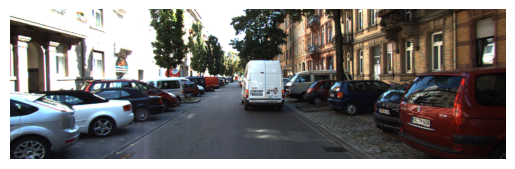

In [ ]:
# Test Plotter class

image_path = r"C:\Users\dhoow\Desktop\Computer Vision\lane_segmentation_project\dummy_kitti_dataset\train_images\000004_10.png"
plotter = Plotter()
plotter.plot_image_from_path(image_path)